CSV Analysis ----> Llama3 + Function calling + E2B code interpreter

* E2B can work with any LLM and AI framework.
* E2B Sandbox allows you to upload and downloads file to and from the Sandbox.
* Tool Name: execute_python



In [1]:
! pip install -q groq e2b_code_interpreter==1.0.0 python-dotenv==1.0.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.6/81.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.9 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
import os
from dotenv import load_dotenv

Groq_api_key = userdata.get('GROQ_API_KEY')
E2B_api_key  = userdata.get('E2B_API_KEY')

In [3]:
# MODEL_NAME = "llama3-8b-8192"
MODEL_NAME = "llama3-70b-8192"

SYSTEM_PROMPT = """You're a python data scientist that is analyzing  Passengers data in Airline. You are given tasks to complete and you run python code to solve them.

Information about the the Airline Dataset:
- It's in the `/content/Airline Dataset.csv` file
- It has following columns (examples included):
  - `Passenger ID`: for example 10856
  - `First Name`: "Edithe"
  - `Last Name`: "Leggis"
  - `Gender`: "Male", "Female"
  - `Age`: 62
  - `Nationality`: "Japan"
  - `Airport Name`: for example Coldfoot Airport
  - `Airport Country Code`: for example US
  - `Country Name`: for example United States
  - `Airport Continent`: for example NAM
  - `Continents`: for example North America
  - `Departure Date`: 6/28/2022
  - `Arrival Airport`: "CXF"
  - `Pilot Name`: "Edithe Leggis",
  - `Flight Status`: "On Time", "Delayed", "Cancelled"

Generally you follow these rules:
- the python code runs in jupyter notebook.
- every time you call `execute_python` tool, the python code is executed in a separate cell. it's okay to multiple calls to `execute_python`.
- display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
- you have access to the internet and can make api requests.
- you also have access to the filesystem and can read/write files.
- you can install any pip package (if it exists) if you need to but the usual packages for data analysis are already preinstalled.
- you can run any python code you want, everything is running in a secure sandbox environment
"""

# Function calling
tools = [
  {
    "type": "function",
      "function": {
        "name": "execute_python",
        "description": "Execute python code in a notebook cell and returns any result, stdout, stderr, display_data, and error.",
        "parameters": {
          "type": "object",
          "properties": {
            "code": {
              "type": "string",
              "description": "The python code to execute in a single cell.",
            }
          },
          "required": ["code"],
        },
      },
  }
]

### code interpreting

In [4]:
def code_interpret(e2b_code_interpreter, code):
  print("Running code interpreter...")
  exec = e2b_code_interpreter.run_code(code,
  on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
  on_stdout=lambda stdout: print("[Code Interpreter]", stdout))

  if exec.error:
    print("[Code Interpreter ERROR]", exec.error)
  else:
    return exec.results

### calling LLM and parsing tools

```
def match_code_blocks(text):
  pattern = re.compile(r'```(?:python)?[\n\r](.*?)```', re.DOTALL)
  return pattern.findall(text)
```
Instead of using the above code, we will use function calling with execute_python

In [5]:
import os
import json
import re
from groq import Groq

client = Groq(api_key=Groq_api_key)

def chat_with_llama(e2b_code_interpreter, user_message):
  print(f"\n{'='*50}\nUser message: {user_message}\n{'='*50}")

  messages = [
      {"role": "system", "content": SYSTEM_PROMPT},
      {"role": "user", "content": user_message}
  ]

  response = client.chat.completions.create(
      model=MODEL_NAME,
      messages=messages,
      tools=tools,
      tool_choice="auto",
      max_tokens=4096,
  )

  response_message = response.choices[0].message
  tool_calls = response_message.tool_calls

  if tool_calls:
    for tool_call in tool_calls:
      function_name = tool_call.function.name
      function_args = json.loads(tool_call.function.arguments)
      if function_name == "execute_python":
        code = function_args["code"]
        code_interpreter_results = code_interpret(e2b_code_interpreter, code)
        return code_interpreter_results
      else:
        raise Exception(f"Unknown tool {function_name}")
  else:
    print(f"(No tool call in model's response) {response_message}")
    return []

###  uploading dataset to E2B Sandbox.

In [7]:
def upload_dataset(code_interpreter):
  print("Uploading dataset to Code Interpreter sandbox...")
  file_path = "/content/Airline Dataset.csv"
  with open(file_path, "rb") as f:
    code_interpreter.files.write(file_path, f)
  print("Uploaded at", file_path)

Uploading dataset to Code Interpreter sandbox...
Uploaded at /content/Airline Dataset.csv

User message: Plot the age distribution of passengers to identify the most common age groups
Running code interpreter...


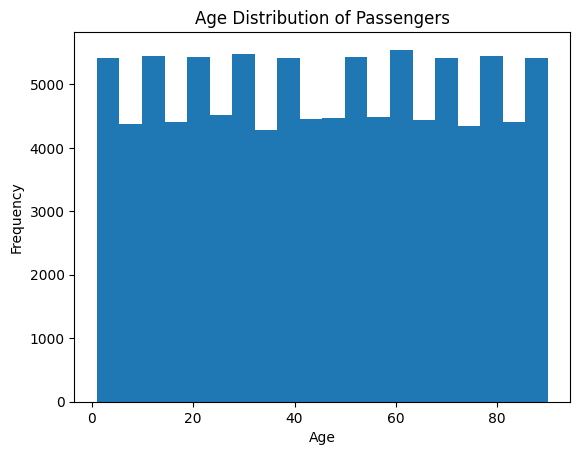

In [8]:
from e2b_code_interpreter import Sandbox


with Sandbox(api_key=E2B_api_key) as code_interpreter:

  # Upload the dataset to the code interpreter sandbox
  upload_dataset(code_interpreter)

  code_results = chat_with_llama(
    code_interpreter,
    "Plot the age distribution of passengers to identify the most common age groups"
  )
  if code_results:
    first_result = code_results[0]
  else:
    raise Exception("No code results")

first_result

Uploading dataset to Code Interpreter sandbox...
Uploaded at /content/Airline Dataset.csv

User message: Plot the number of Male passengers by nationality
Running code interpreter...


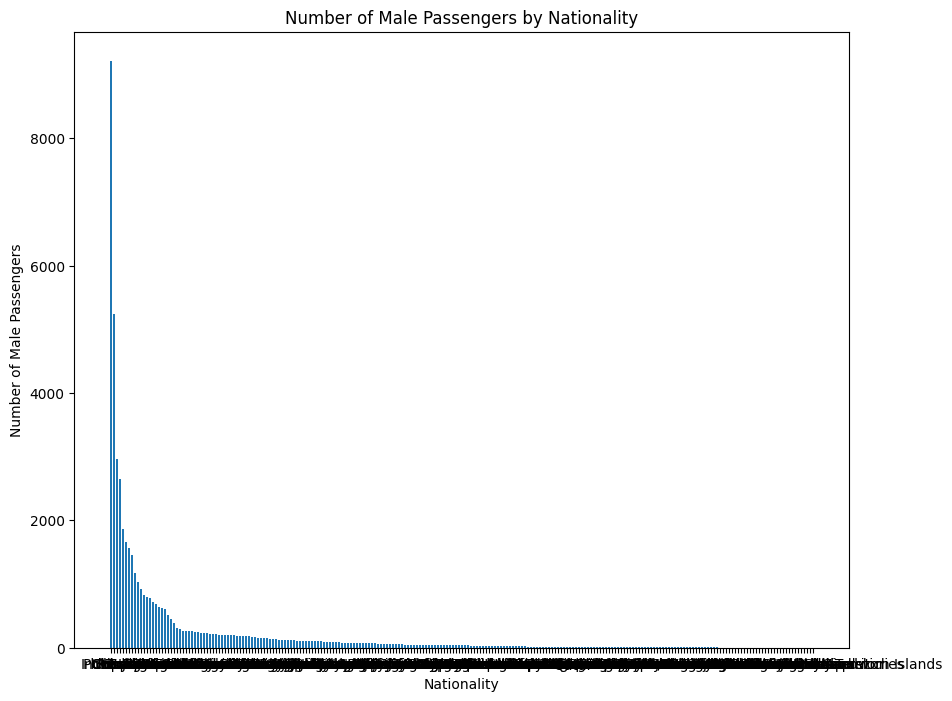

In [9]:
from e2b_code_interpreter import Sandbox


with Sandbox(api_key=E2B_api_key) as code_interpreter:

  # Upload the dataset to the code interpreter sandbox
  upload_dataset(code_interpreter)

  code_results = chat_with_llama(
    code_interpreter,
    "Plot the number of Male passengers by nationality"
  )
  if code_results:
    first_result = code_results[0]
  else:
    raise Exception("No code results")

first_result

Uploading dataset to Code Interpreter sandbox...
Uploaded at /content/Airline Dataset.csv

User message: Plot the average number of passengers for Japanese nationals
Running code interpreter...
[Code Interpreter] Average number of passengers for Japanese nationals: 1805



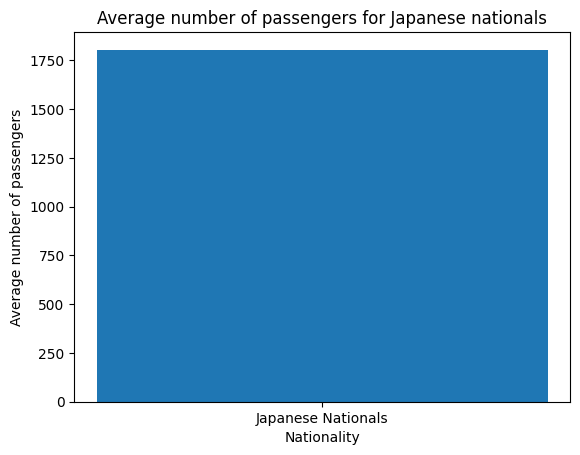

In [7]:
from e2b_code_interpreter import Sandbox


with Sandbox(api_key=E2B_api_key) as code_interpreter:

  # Upload the dataset to the code interpreter sandbox
  upload_dataset(code_interpreter)

  code_results = chat_with_llama(
    code_interpreter,
    "Plot the average number of passengers for Japanese nationals"
  )
  if code_results:
    first_result = code_results[0]
  else:
    raise Exception("No code results")


first_result

Uploading dataset to Code Interpreter sandbox...
Uploaded at /content/Airline Dataset.csv

User message: Plot the line or bar chart of the number of flights over time based on Departure Date to see peak travel periods
Running code interpreter...


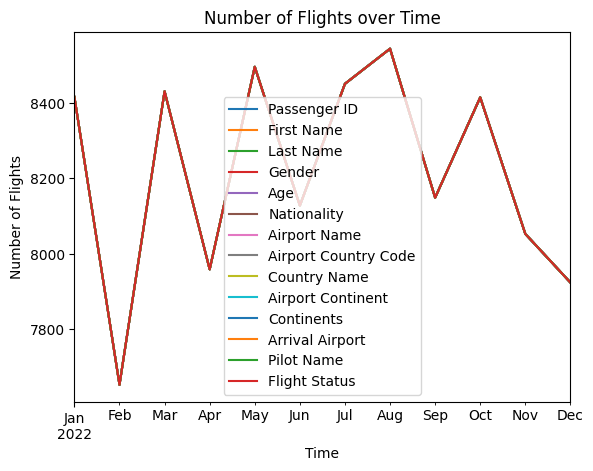

In [11]:
from e2b_code_interpreter import Sandbox


with Sandbox(api_key=E2B_api_key) as code_interpreter:

  # Upload the dataset to the code interpreter sandbox
  upload_dataset(code_interpreter)

  code_results = chat_with_llama(
    code_interpreter,
    "Plot the line or bar chart of the number of flights over time based on Departure Date to see peak travel periods"
  )
  if code_results:
    first_result = code_results[0]
  else:
    raise Exception("No code results")


first_result

Uploading dataset to Code Interpreter sandbox...
Uploaded at /content/Airline Dataset.csv

User message: Plot the bar chart showing the number of flights departing from each Airport Country Code to identify the busiest departure countries
Running code interpreter...


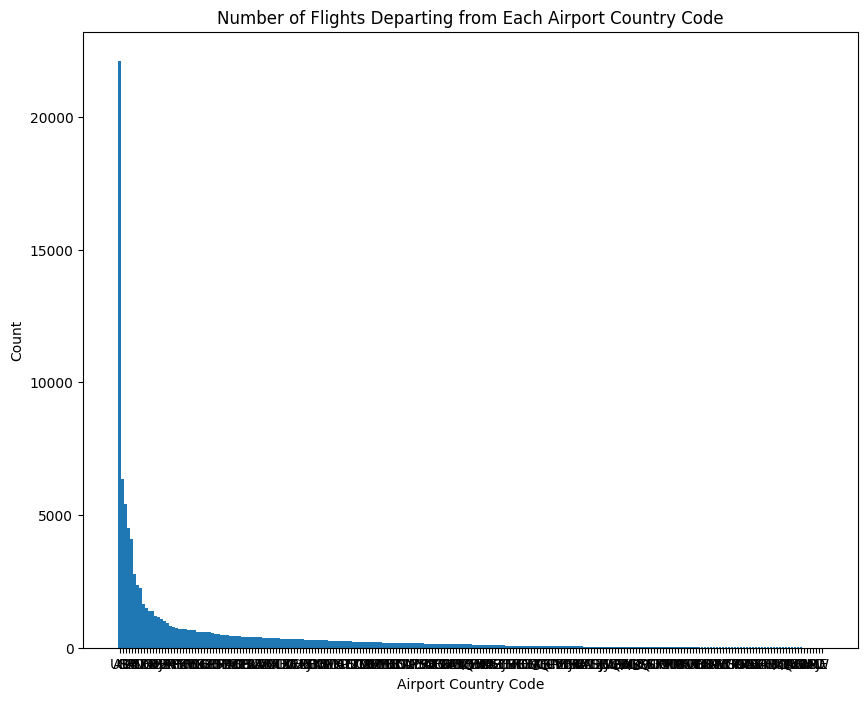

In [12]:
from e2b_code_interpreter import Sandbox


with Sandbox(api_key=E2B_api_key) as code_interpreter:

  # Upload the dataset to the code interpreter sandbox
  upload_dataset(code_interpreter)

  code_results = chat_with_llama(
    code_interpreter,
    "Plot the bar chart showing the number of flights departing from each Airport Country Code to identify the busiest departure countries"
  )
  if code_results:
    first_result = code_results[0]
  else:
    raise Exception("No code results")


first_result

In [18]:
from e2b_code_interpreter import Sandbox


with Sandbox(api_key=E2B_api_key) as code_interpreter:

  # Upload the dataset to the code interpreter sandbox
  upload_dataset(code_interpreter)

  chat_with_llama(
    code_interpreter,
    "Number of flights departing from each Airport Country Code to identify the busiest departure countries"
  )


Uploading dataset to Code Interpreter sandbox...
Uploaded at /content/Airline Dataset.csv

User message: Number of flights departing from each Airport Country Code to identify the busiest departure countries
Running code interpreter...
[Code Interpreter]     Airport Country Code  count
0                     US  22104
1                     AU   6370
2                     CA   5424
3                     BR   4504
4                     PG   4081
..                   ...    ...
230                   NR      7
231                   MC      7
232                   AD      7
233                   PW      5
234                   JE      4

[235 rows x 2 columns]



In [15]:
from e2b_code_interpreter import Sandbox


with Sandbox(api_key=E2B_api_key) as code_interpreter:

  # Upload the dataset to the code interpreter sandbox
  upload_dataset(code_interpreter)

  chat_with_llama(
    code_interpreter,
    "Number of female passengers are there"
  )


Uploading dataset to Code Interpreter sandbox...
Uploaded at /content/Airline Dataset.csv

User message: Number of female passengers are there
Running code interpreter...
[Code Interpreter] 49021



In [16]:
from e2b_code_interpreter import Sandbox


with Sandbox(api_key=E2B_api_key) as code_interpreter:

  # Upload the dataset to the code interpreter sandbox
  upload_dataset(code_interpreter)

  chat_with_llama(
    code_interpreter,
    "Number of unique female passengers are there"
  )

Uploading dataset to Code Interpreter sandbox...
Uploaded at /content/Airline Dataset.csv

User message: Number of unique female passengers are there
Running code interpreter...
[Code Interpreter] 4954

